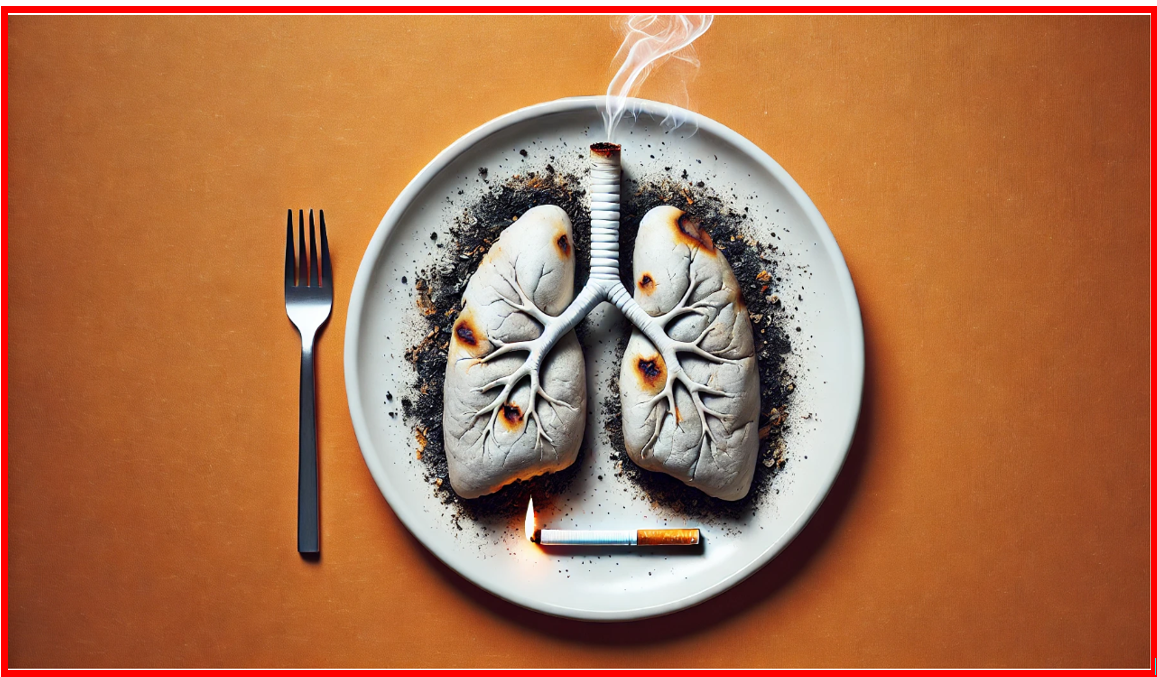


# Smoker Dataset
## Module 10.13 Assignment 10: Final Project
Dec. 2024

Authors: Tyler Earps, Ryan Smith, Basil Mullings, & Ean Vandergraaf


## Abstract and Data Description


### Abstract

This team project will use the Kaggle Smoker Dataset with 150+K rows and 20+ columns, which aims to analyze patterns and identify predictor items related to smoking habits.  This is a rather different/unique dataset – meaning that the data is not actually collected/procured over time, but instead was synthetically generated from another dataset using a deep learning model.  By examining a variety of demographic, lifestyle, and health-related variables, our study seeks to uncover any meaningful associations that could possible influence an individual's likelihood of smoking. Using exploratory data analysis and supervised machine learning models, such as logistic regression, decision trees, and possible ensemble methods, we will strive to identify key features that distinguish smokers from non-smokers. Our findings from this analysis could possible inform public health strategies by highlighting significant factors contributing to smoking behavior, and ultimately supporting targeted interventions and health education efforts, and even possible significant life style changes.  This is a binary classification task, and we hope that additional feature engineering aspects of the dataset will also be fruitful.


https://www.kaggle.com/competitions/playground-series-s3e24/data?select=train.csv


<div style="border-radius: 10px; background-color: #F4A300 ">
    <h1 style="color: white; padding: 1rem">      Data Attributes detail     </h1>
</div>


A quick breakdown on information the dataset contains. It has the following **features** (columns):

- **<span style="color: turquoise">age</span>**: Age in years
- **<span style="color: turquoise">height(cm)</span>**: Height of the person in Centimeters
- **<span style="color: turquoise">weight(kg)</span>**: Weight of the person in Kilograms
- **<span style="color: turquoise">waist(cm)</span>**: Waist length in centimeters
- **<span style="color: turquoise">eyesight(left)</span>**: Vision measurement in the left eye
- **<span style="color: turquoise">eyesight(right)</span>**: Vision measurement in the right eye
- **<span style="color: turquoise">hearing(left)</span>**: Hearing measurement in the left ear
- **<span style="color: turquoise">hearing(right)</span>**: Hearing measurement in the right ear
- **<span style="color: turquoise">systolic</span>**: Systolic blood pressure, amount of pressure experienced by the arteries when the heart is contracting
- **<span style="color: turquoise">relaxation</span>**: Blood pressure (diastolic), amount of pressure experienced by the arteries when the heart is relaxing
- **<span style="color: turquoise">fasting blood sugar</span>**: This measures blood sugar after an overnight fast (not eating)
- **<span style="color: turquoise">Cholesterol</span>**: Measure of cholesterol levels
- **<span style="color: turquoise">triglyceride</span>**: Amount of simple and neutral lipids in blood
- **<span style="color: turquoise">HDL</span>**: High Density Lipoprotein, "good" cholesterol, absorbs cholesterol in the blood and carries it back to the liver
- **<span style="color: turquoise">LDL</span>**: Low Density Lipoprotein, "bad" cholesterol, makes up most of body's cholesterol. High levels of this raise risk for heart disease and stroke.
- **<span style="color: red">hemoglobin</span>**: Protein contained in red blood cells that delivers oxygen to the tissues
- **<span style="color: turquoise">Urine protein</span>**: Measure of protein in urine
- **<span style="color: turquoise">serum creatinine</span>**: Creatinine level, Creatinine is a waste product in your blood that comes from muscles. Healthy kidneys filter creatinine out of your blood through urine
- **<span style="color: turquoise">AST</span>**: Aspartate transaminase, an enzyme that helps the body break down amino acids. It's usually present in blood at low levels. An increase in AST levels may mean liver damage, liver disease or muscle damage
- **<span style="color: turquoise">ALT</span>**: Alanine transaminase, an enzyme found in the liver that helps convert proteins into energy for the liver cells. When the liver is damaged, ALT is released into the bloodstream and levels increase
- **<span style="color: turquoise">Gtp</span>**: Energy-rich nucleotide analogous to ATP
- **<span style="color: turquoise">dental caries</span>**: Dental issue of the person (boolean)
- **<span style="color: green">smoking</span>**: Whether the person smokes or not.  This is our target variable.

### Stage 0: Import Data

In [9]:
# Downlod the data
# https://www.kaggle.com/competitions/playground-series-s3e24/data?select=train.csv

# Extract train.csv & test.csv to folder "./Data" in the same directory as repo

#=> Number of rows and columns:
Rows: 159256, Columns: 24


#=> Summary of statistics for our Training data :
+-------+-----------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|               id|               age|       height(cm)|        weight(kg)|        waist(cm)|     eyesight(left)|   eyesight(right)|      hearing(left)|     hearing(right)|          systolic|       relaxation|fasting blood sugar|       Cholesterol|      triglyceride|               HDL|               LDL|        hemoglobin|     Urine protein|  serum creatinine|               AST|               ALT|               

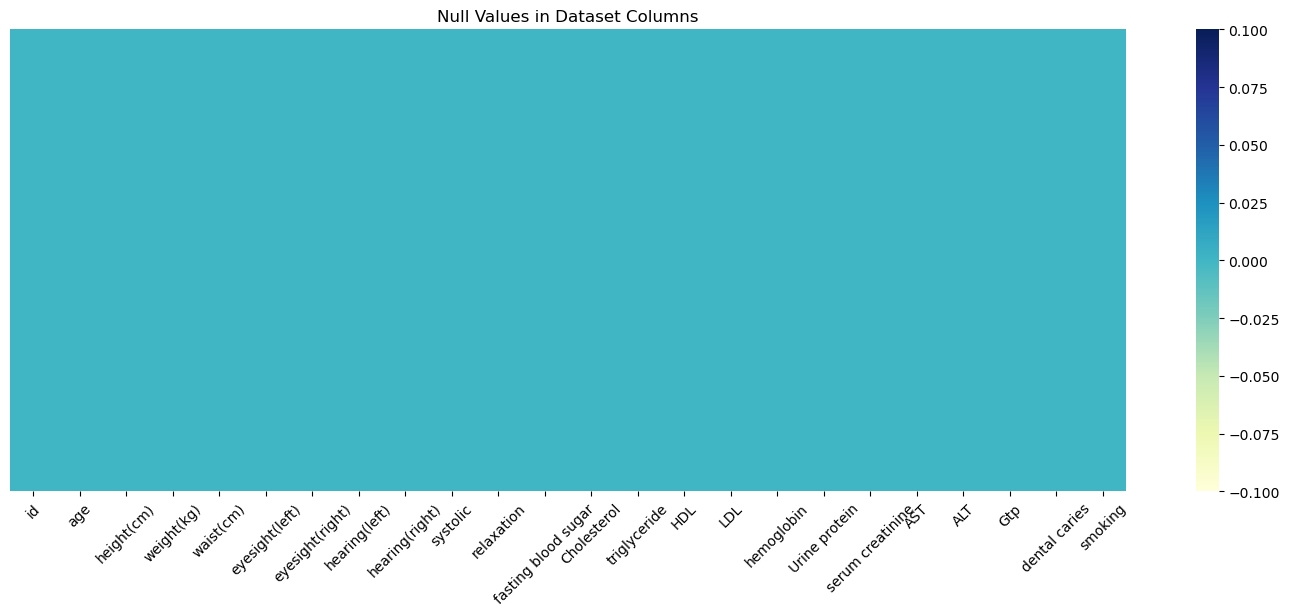

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, mean, countDistinct, format_number, when, explode, lower
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from sklearn.metrics import classification_report, roc_curve, auc

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("SmokerStatusPrediction").getOrCreate()

###Loading the Dataset

#file_path = "data/train.csv"
#data = spark.read.csv(file_path, header=True, inferSchema=True)

#Load Kaggle data into a DataFrame
def csvToDF(fileName):
    return spark.read\
                .format("csv")\
                .option("header", "true")\
                .option('escape','"')\
                .load(fileName)

    
df_train = csvToDF("data/train.csv")
df_test = csvToDF("data/test.csv")

#Cast all columns to double
df_train = df_train.select([col(column).cast('double') for column in df_train.columns])
df_test = df_test.select([col(column).cast('double') for column in df_test.columns])


##Show the number of rows and columns in one statement
print('#=> Number of rows and columns:')
print(f"Rows: {df_train.count()}, Columns: {len(df_train.columns)}")
print("\n")

##Show our basic statistics
print('#=> Summary of statistics for our Training data :')
df_train.summary().show()
print("\n")

##Show the data schema
print('#=> Training data schema:')
df_train.printSchema()
print("\n")

##List the column names 
print('#=> Column names:')
print(df_train.columns)
print("\n")

##Verify any null relevant data in any of our columns.
print('#=> Training dataset with Null values:')
df_train.select([count(when(col(c).isNull(), c )).alias(c) for c in df_train.columns]).show()
print("\n")


##Count the number of null values in each column
null_counts = df_train.select([count(when(col(c).isNull(), c)).alias(c) for c in df_train.columns])

##Convert the result to Pandas for easy viewing
null_counts_pandas = null_counts.toPandas()

##Transpose the Pandas DataFrame for better readability
null_counts_pandas = null_counts_pandas.T  
null_counts_pandas.columns = ['null_count']  

##Display the transposed result in a clean tabular format
print(null_counts_pandas)
print("\n\n")


###
#null values if present, are displayed in lighter shades  
#for each of the colums and non-null values in darker shades.
#Since only the lighter shade is displayd, this confirms that no null values are present in the dataset.
#The heatmap will help us to visually inspect where zeros are located across the columns. 
#If we find no darker shaded cells, that means there are no nulls in the dataset.


##Create a mask for null values by checking each column for null
null_mask = df_train.select([((col(c).isNull()).cast("int")).alias(c) for c in df_train.columns])

##Convert the PySpark DataFrame to a Pandas DataFrame
null_mask_pd = null_mask.toPandas()

##Plot the heatmap showing any null columns with particular colors.
plt.figure(figsize=(18, 6))
sns.heatmap(null_mask_pd, cmap="YlGnBu", cbar=True, xticklabels=null_mask_pd.columns, yticklabels=False)
plt.title("Null Values in Dataset Columns")
plt.xticks(rotation=45)
plt.show()


##Let's aggregate the number of items in each column.
#print("\n\n")
#for column in df_train.columns:
#    df_train.groupBy(column).count().show()




### Stage 1: Data Preparation

<i>EDA & Any adjustments to clean the data</i>

+-------+-----------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|               id|               age|       height(cm)|        weight(kg)|        waist(cm)|     eyesight(left)|   eyesight(right)|      hearing(left)|     hearing(right)|          systolic|       relaxation|fasting blood sugar|       Cholesterol|      triglyceride|               HDL|               LDL|        hemoglobin|     Urine protein|  serum creatinine|               AST|               ALT|               Gtp|     dental caries|            smoking|
+-------+-----------------+------------------+-----------------+--

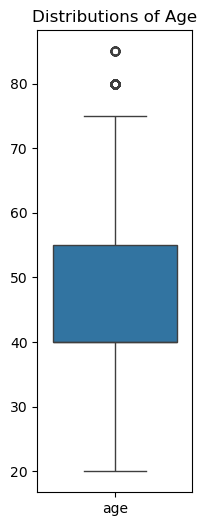

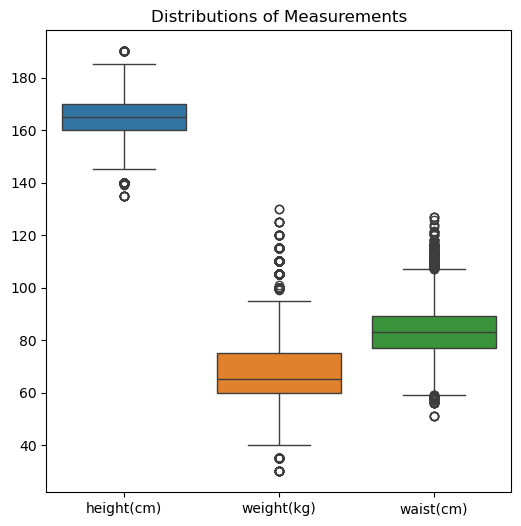

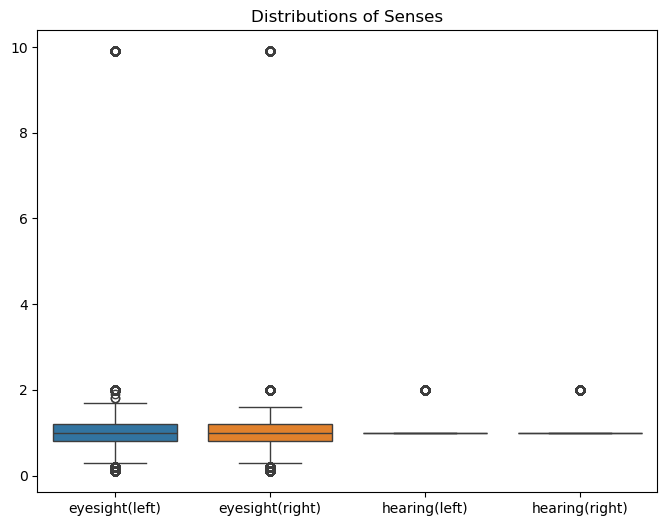

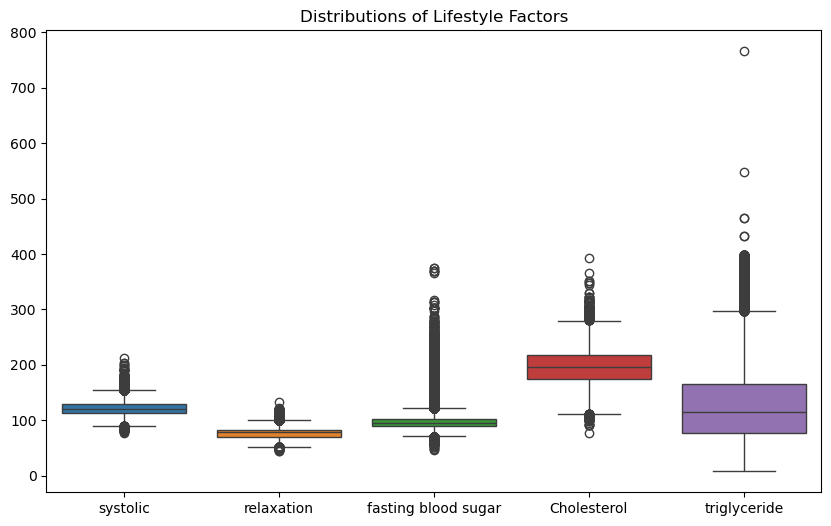

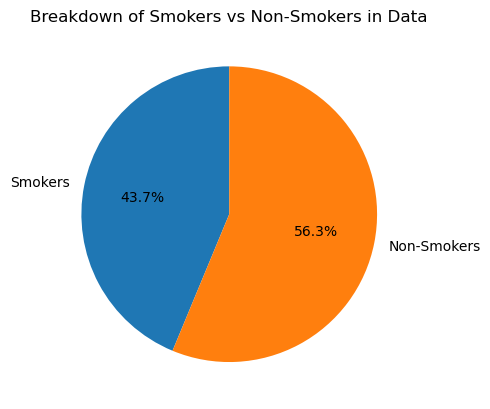

We have a decently balanced target variable of smokers vs non-smokers


#=>  Overall distribution of features:


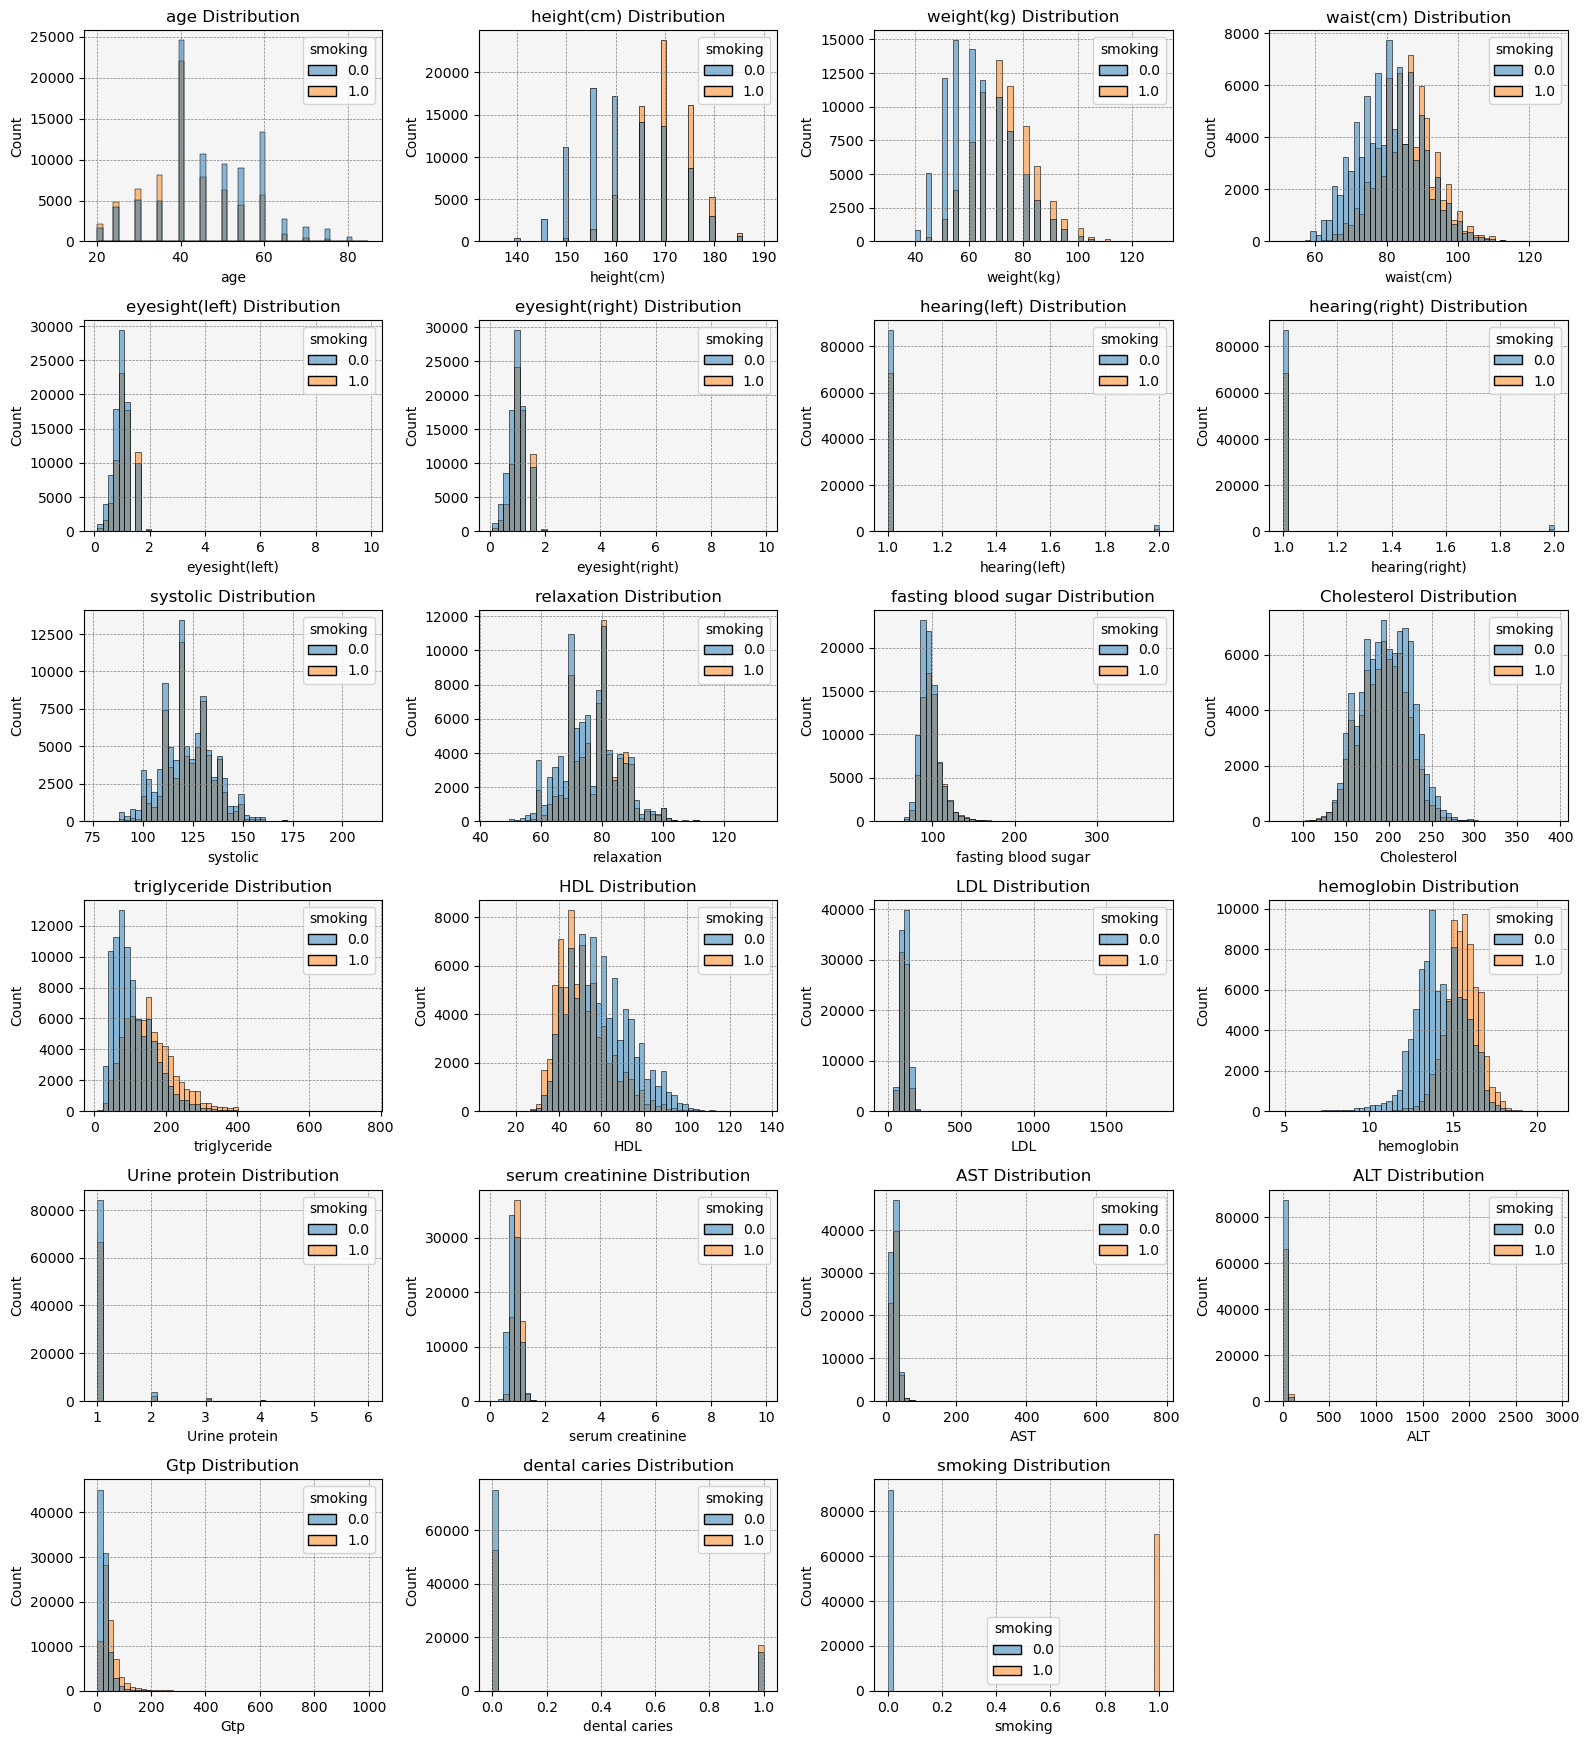

In [14]:

df_train.describe().show()


##Doesn't really need the id column, so drop it.
#df_train = df_train.drop('id', 'LDL')
df_train = df_train.drop('id')



###Check if there are any duplicte rows, and drop them.
##Group by all columns and count the occurrences
duplicates = df_train.groupBy(df_train.columns).count()

##Filter rows where count > 1, indicating duplicates
duplicates = duplicates.filter(duplicates['count'] > 1)

##Show the duplicate rows (if any), then drop them.
if duplicates.count() > 0:
    print("There are duplicate rows in the DataFrame.")
    duplicates.show()  

    ##Drop duplicate rows
    df_train = df_train.dropDuplicates()
    
else:
    print("There are no duplicate rows in the Dataset.")


# Find most important features
# Do some box and whisker charts
# Decide if any transformations need to be made

def box_chart(df, title):
    plt.figure(figsize=(len(df.columns)*2, 6))
    sns.boxplot(data=df)
    plt.title(title)
    plt.show()

## Distributions
print('\nDistributions within the dataset')
df_train_age = df_train.select('age').toPandas()
box_chart(df_train_age,"Distributions of Age")

df_train_measurements = df_train.select('height(cm)', 'weight(kg)', 'waist(cm)').toPandas()
box_chart(df_train_measurements,"Distributions of Measurements")

df_train_senses = df_train.select('eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)').toPandas()
box_chart(df_train_senses,"Distributions of Senses")

df_train_lifestyle = df_train.select('systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride').toPandas()
box_chart(df_train_lifestyle,"Distributions of Lifestyle Factors")

## Binary Analysis
df_train_smokers = df_train.filter('smoking == 1').count()
df_train_non_smokers = df_train.filter('smoking == 0').count()
y = np.array([df_train_smokers, df_train_non_smokers])
labels = ['Smokers', 'Non-Smokers']
plt.title('Breakdown of Smokers vs Non-Smokers in Data')
plt.pie(y, labels = labels, autopct='%1.1f%%', startangle=90)
plt.show() 

print("We have a decently balanced target variable of smokers vs non-smokers\n")



###Additional Distribution of features
##We can see below that some features have skewed distrubutions. 
##Features such as hemoglobin and waist have some clear differences in their particular smoking distributions.

##Convert PySpark DataFrame to Pandas DataFrame
df_train_pandas_distr = df_train.toPandas()

##Determine the number of columns for the plots
num_cols = len(df_train_pandas_distr.columns)

##Set up the figure size based on the number of columns
plt.figure(figsize=(16, num_cols*1.5))

##Create a subplot for each column in the DataFrame
for i, col in enumerate(df_train_pandas_distr.columns):
    
    ##Adjust the number of rows and columns in the subplot grid
    plt.subplot(num_cols // 2 + num_cols % 2, 4, i + 1)  
    sns.histplot(x=col, hue='smoking', data=df_train_pandas_distr, bins=50) 
    plt.title(f'{col} Distribution')  
    
    ##Customize background gridlines
    plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.5)
    
    ##Adjust the background color of the plot area for better contrast with gridlines.
    plt.gca().set_facecolor('whitesmoke')  
    
    ##Automatically adjust subplot parameters to give specified padding
    plt.tight_layout()  

##Now show overall distribution of features
print('\n#=>  Overall distribution of features:')
plt.show()




Overall, the dataset is very clean with lots of good data to indicate if someone smokes based on physical characteristics. The data is very uniform and in line with what you would expect from physical characteristics including items like age, height, weight, and much more. It also contains a 43.7% smokers to 56.3% Non-Smokers with a good overlap between characteristics, giving a good baseline for comparison between the two to identify potential patterns.

### Stage 2: Feature Extraction & Engineering



#=> Displaying processed train data:
+--------------------------------------------------------------------------------------------------------------------------------+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                        |smoking|scaled_features                                                                                                                                                                                                                                                     

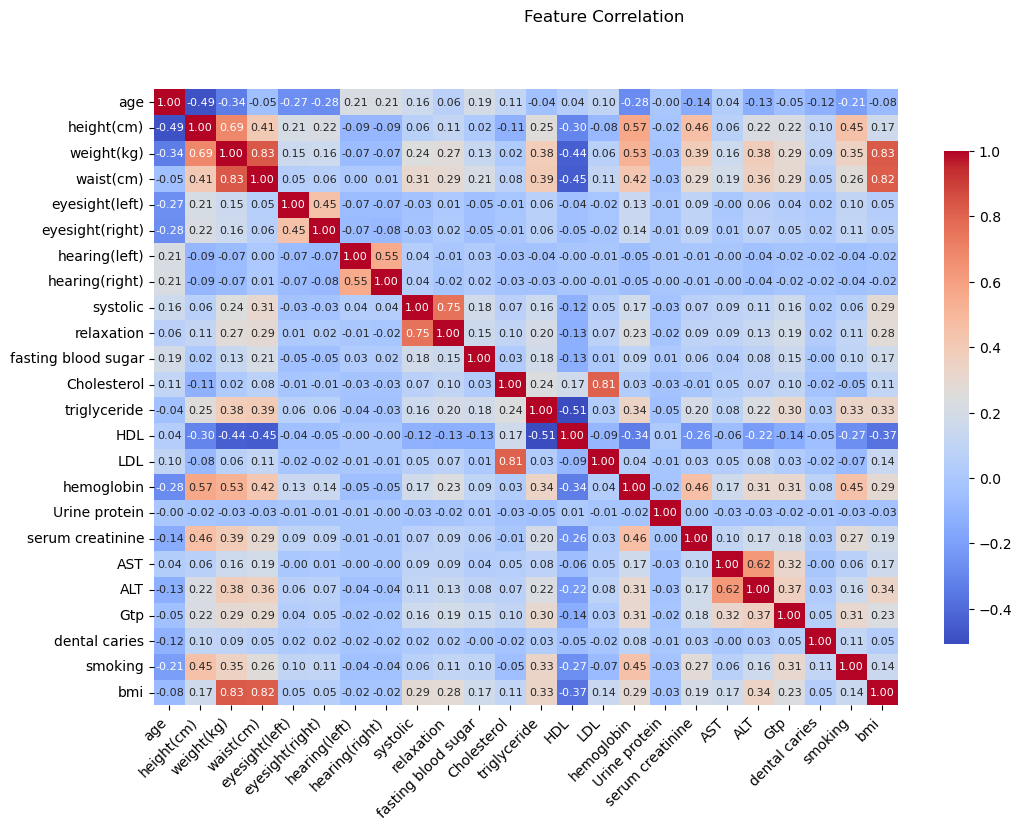

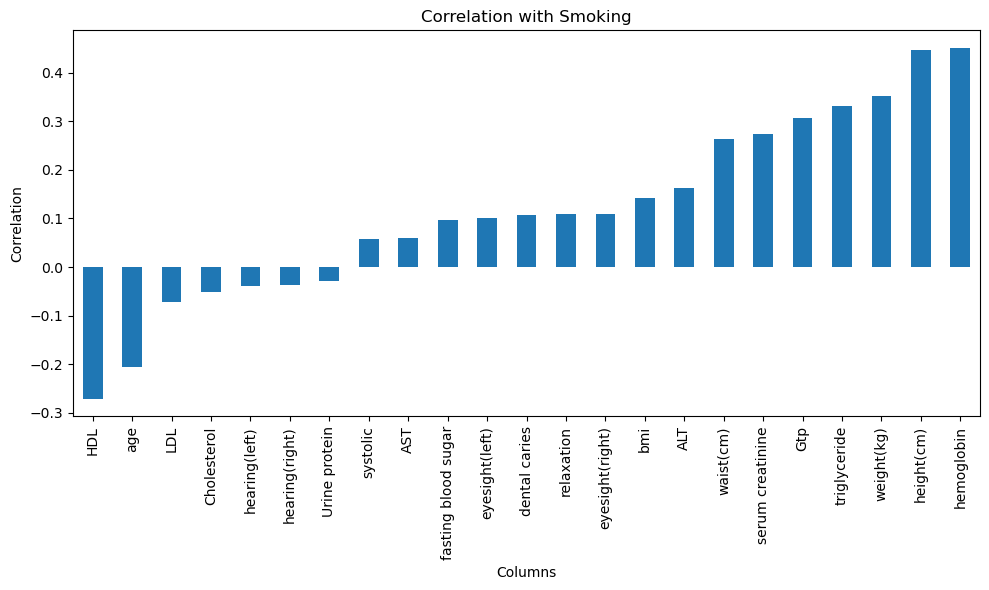

In [18]:
#from pyspark.ml.feature import FeatureHasher
#from pyspark.sql.functions import concat
#from pyspark.ml.feature import VectorAssembler, StandardScaler


##Create a new feature called 'bmi' (Body Mass Index) that combines weight and height.
##This can provide insights into the correlation between smoking and obesity-related health factors.
df_train = df_train.withColumn('bmi', df_train['weight(kg)'] / (df_train['height(cm)'] / 100)**2)

# Split data from label
x_features = ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'bmi']
y_features = ['smoking']


##Assemble features
#assembler = VectorAssembler(inputCols=x_features, outputCol="scaled_features")
assembler = VectorAssembler(inputCols=x_features, outputCol="features")
#transformed_data = assembler.transform(df_train)
#transformed_data = assembler.transform(df_train).select("scaled_features", "smoking") 
transformed_data = assembler.transform(df_train).select("features", "smoking") 

##Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaled_data = scaler.fit(transformed_data).transform(transformed_data)

#df_train_x = transformed_data
#scaled_data = df_train_x
df_train_x = scaled_data

# Now display 2 rows of the processed train data.
print("\n")
print('#=> Displaying processed train data:')
df_train_x.show(n=2, truncate=False)


##Calculate correlations between the columns and smoking.
feature_columns = [col for col in df_train.columns if col != 'smoking']
for col_name in feature_columns:
    correlation = df_train.stat.corr(col_name, 'smoking')
    print(f"Correlation between {col_name} and smoking: {correlation}")


##Now convert to Pandas for visualization
pandas_data = df_train.toPandas()

##Increase the figure size
plt.figure(figsize=(12, 8))

##Create the correlation heatmap with a smaller annotation font size and rotated labels
sns.heatmap(pandas_data.corr(), annot=True, cmap="coolwarm", fmt='.2f',
            annot_kws={'size': 8},  
            cbar_kws={'shrink': 0.8})  

##Rotate the axis labels for better readability
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.suptitle('Feature Correlation')

##Show the plot
print("\nNow displaying the correlation amongst the columns and smoking: ")
plt.show()



####Plot the values relative to smoking.

##Calculate correlations between the columns and 'smoking'
#feature_columns = [col for col in df_train.columns if col != 'smoking']
correlations = {}

for col_name in feature_columns:
    correlation = df_train.stat.corr(col_name, 'smoking')
    correlations[col_name] = correlation

##Convert the correlations dictionary to a Pandas DataFrame
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Column', 'Correlation'])

##Sort the correlations by their values and drop 'smoking'
correlation_df_sorted = correlation_df.sort_values(by='Correlation').drop('smoking', errors='ignore')

##Plot the sorted correlations as a bar chart
correlation_df_sorted.set_index('Column').plot(kind='bar', legend=False, figsize=(10, 6))

##Customize the plot
plt.title('Correlation with Smoking')
plt.xlabel('Columns')
plt.ylabel('Correlation')
plt.tight_layout()

##Display the plot
plt.show()






When comparing traits, there are some correlations worth noting. First, some physical characteristics seen in the confusion matrix like height and weight seem to be very correlated to one another, which could influence the accuracy of our models later to a small degree. To verify this connection, we decided on adding a column for BMI, which will help paint a better picture for health related to smoking. Looking at correlation with smoking, most of our data has a positive correlation with smoking while a few stats have negatives. This makes since logically, as something like age doesnt have a logical impact on someones ability to smoke. None of the negatives were worth dropping, as all of the stats help determine smoking characteristics.

**Highest Positive Correlation**
* Hemogoblin
* Height
* Weight
* Triglyceride

**Highest Negative Correlation**
* HDL
* Age

### Stage 3: Machine Learning Algorithm Preparation and Parameter Tuning

In [22]:
####Supervised Machine Learning Models

# Train-test split
train, test = scaled_data.randomSplit([0.8, 0.2], seed=42)

evalScores = {}
accuracies = []
precisions = []
recalls = []
f1s = []

#'''
##Logistic Regression
print("\nNow working on Logistic Regression ...")
lr = LogisticRegression(featuresCol="scaled_features", labelCol="smoking")
lr_model = lr.fit(train)

##Logistic Regression Predictions
lr_predictions = lr_model.transform(test)
print("done!!")
#'''



#'''
##Decision Tree
##Instantiate Decision Tree Classifier with some initial hyperparameters
from pyspark.ml.classification import DecisionTreeClassifier
print("\nNow working on Decision Tree ...")
dt = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="smoking",  maxDepth=5, maxBins=32)
dt_model = dt.fit(train)

##Decision Tree Predictions
dt_predictions = dt_model.transform(test)
print("done!!")
#'''



#'''
##Random Forest
print("\nNow working on Random Forest ...")
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="smoking")
rf_model = rf.fit(train)

##Random Forest Predictions
rf_predictions = rf_model.transform(test)
print("done!!")
#'''



#'''
##Gradient-Boosted Trees
print("\nNow working on Gradient Boost ...")
gbt = GBTClassifier(featuresCol="scaled_features", labelCol="smoking")
gbt_model = gbt.fit(train)

##Gradient Boost Predictions
gbt_predictions = gbt_model.transform(test)
print("done!!")
#'''




Now working on Logistic Regression ...
done!!

Now working on Decision Tree ...
done!!

Now working on Random Forest ...
done!!

Now working on Gradient Boost ...
done!!


In [ ]:
###Neural network option - Multilayer Perceptron Classifier (MLP) in PySpark



from pyspark.ml.classification import MultilayerPerceptronClassifier

print("\nNow working on Neural network option - Multilayer Perceptron Classifier ...")


##Define MLP structure: [input size, hidden layers, output size]
input_size = len("features")

##Example structure with 2 hidden layers
layers = [input_size, 32, 16, 2]  
mlp = MultilayerPerceptronClassifier(labelCol="smoking", featuresCol="scaled_features", layers=layers, seed=42, maxIter=100)

##Train the MLP model
mlp_model = mlp.fit(train)

##Predict on the test set
mlp_predictions = mlp_model.transform(test)

##Evaluate AUC
evaluator = BinaryClassificationEvaluator(labelCol="smoking", metricName="areaUnderROC")
mlp_auc = evaluator.evaluate(mlp_predictions)
print(f"MLP AUC: {mlp_auc}")

##Evaluate Accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
mlp_accuracy = multiclass_evaluator.evaluate(mlp_predictions)
print(f"MLP Accuracy: {mlp_accuracy}")

##Confusion Matrix
conf_matrix = mlp_predictions.groupBy("smoking", "prediction").count()
conf_matrix.show()

##Convert Confusion Matrix to Pandas for Visualization
conf_matrix_pd = conf_matrix.toPandas()
pivot = conf_matrix_pd.pivot(index=target_col, columns="prediction", values="count")

##Plot Confusion Matrix
sns.heatmap(pivot, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for MLP")
plt.show()

print("done!!")



Now working on Neural network option - Multilayer Perceptron Classifier ...


Along with the tree based type models such as Decision Tree, Random Forest, etc, we also experimented 
with a supervised Neural network option - Multilayer Perceptron Classifier (MLP).
Initially, this also was looking promising, and it just kept running.
However, running it did...and really never stopped.  After 25 hours - it was still running and using up
approximatley 92% of the CPU.  So, no tangible results were obtained from it.
Perhaps more powerful machines with even GPU's may be needed.


### Stage 4: Model Evaluation


#### Logistic Regresssion Evaluation

Logistic Regression AUC: 0.8358880796406447
Logistic Regression Accuracy: 0.7508116115611309
Logistic Regression Precision: 0.7527918249941064
Logistic Regression Recall: 0.750811611561131
Logistic Regression F1 Score: 0.7514192400899184
+-------+----------+-----+
|smoking|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|10216|
|    0.0|       1.0| 4311|
|    1.0|       0.0| 3595|
|    0.0|       0.0|13605|
+-------+----------+-----+



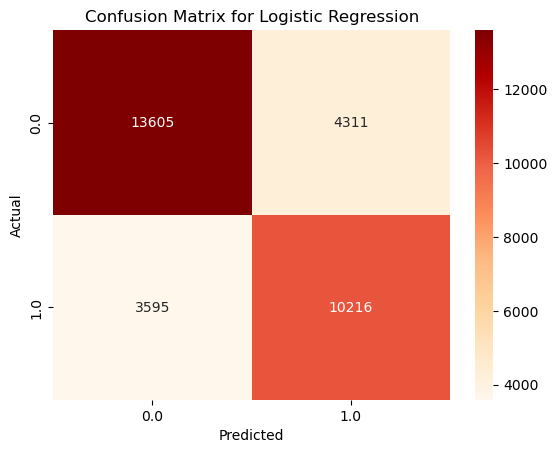

In [27]:
###Evaluate Logistic Regression

##Binary Classification Evaluator for AUC
evaluator = BinaryClassificationEvaluator(labelCol="smoking", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc}")

##Multiclass Classification Evaluator for accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="smoking", predictionCol="prediction", metricName="accuracy")
lr_accuracy = multiclass_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")

precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(lr_predictions)
print(f"Logistic Regression Precision: {precision}")

recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(lr_predictions)
print(f"Logistic Regression Recall: {recall}")

f1 = multiclass_evaluator.setMetricName("f1").evaluate(lr_predictions)
print(f"Logistic Regression F1 Score: {f1}")

evalScores["Logistic Regresssion"] = {"accuracy": lr_accuracy, "precision": precision, "recall": recall, "f1": f1}
accuracies.append(lr_accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)


lr_predictions.groupBy("smoking", "prediction").count().show()


##Convert predictions to Pandas DataFrame
lr_pandas_predictions = lr_predictions.select("smoking", "prediction").toPandas()

##Create a confusion matrix
confusion_matrix = pd.crosstab(lr_pandas_predictions["smoking"], lr_pandas_predictions["prediction"], rownames=["Actual"], colnames=["Predicted"])

##Plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()





####  Decision Tree Evaluation

Logistic Regression AUC Score: 0.7303481541362731
Logistic Regression Accuracy: 0.7534907176852523
Cross-Validated Logistic Regression AUC Score: 0.7303481541362731
Cross-Validated Logistic Regression Accuracy: 0.7534907176852523
Logistic Regression Precision: 0.7604258758808037
Logistic Regression Recall: 0.7534907176852523
Logistic Regression F1 Score: 0.7545132242477359
+-------+----------+-----+
|smoking|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|10805|
|    0.0|       1.0| 4815|
|    1.0|       0.0| 3006|
|    0.0|       0.0|13101|
+-------+----------+-----+



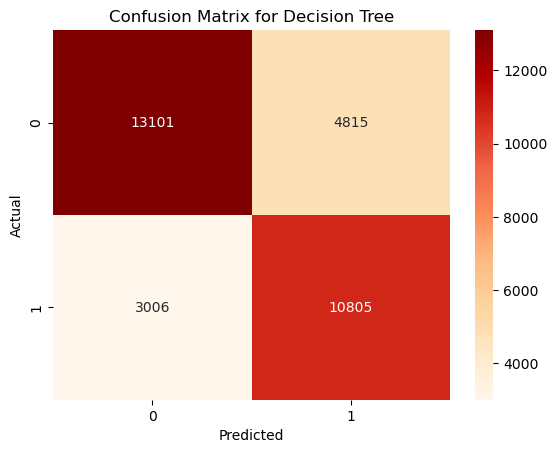

In [29]:
###Evaluate Decision  Tree Model
##Evaluate AUC using BinaryClassificationEvaluator


evaluator = BinaryClassificationEvaluator(labelCol="smoking", metricName="areaUnderROC")
auc_score = evaluator.evaluate(dt_predictions)
print(f"Logistic Regression AUC Score: {auc_score}")

##Evaluate Accuracy using MulticlassClassificationEvaluator
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="smoking", predictionCol="prediction", metricName="accuracy")
accuracy = multiclass_evaluator.evaluate(dt_predictions)
print(f"Logistic Regression Accuracy: {accuracy}")



##Cross-Validation with Hyperparameter Tuning
##Define the parameter grid
#paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [3, 5, 10]).addGrid(dt.maxBins, [16, 32, 64]).build()
paramGrid = ParamGridBuilder().addGrid(dt.maxBins, [16, 32, 64]).build()


##CrossValidator setup
crossval = CrossValidator(
    estimator=dt,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

##Perform cross-validation and fit the best model
cv_model = crossval.fit(train)

##Evaluate the best model
cv_predictions = cv_model.transform(test)
cv_auc_score = evaluator.evaluate(cv_predictions)
cv_accuracy = multiclass_evaluator.evaluate(cv_predictions)

print(f"Cross-Validated Logistic Regression AUC Score: {cv_auc_score}")
print(f"Cross-Validated Logistic Regression Accuracy: {cv_accuracy}")

precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(cv_predictions)
print(f"Logistic Regression Precision: {precision}")

recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(cv_predictions)
print(f"Logistic Regression Recall: {recall}")

f1 = multiclass_evaluator.setMetricName("f1").evaluate(cv_predictions)
print(f"Logistic Regression F1 Score: {f1}")

evalScores["Decision Tree"] = {"accuracy": cv_accuracy, "precision": precision, "recall": recall, "f1": f1}
accuracies.append(cv_accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

##Confusion Matrix
conf_matrix = dt_predictions.groupBy("smoking", "prediction").count()
conf_matrix.show()

##Convert Confusion Matrix to Pandas for Visualization
conf_matrix_pd = conf_matrix.toPandas()
pivot = conf_matrix_pd.pivot(index="smoking", columns="prediction", values="count")

##Plot Confusion Matrix
sns.heatmap(pivot, annot=True, fmt="d", cmap="OrRd", xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Decision Tree")
plt.show()


 #### Gradient Boost Evaluation

Gradient-Boosted Trees AUC: 0.8550821095796989
Gradient-Boosted Trees Accuracy: 0.7718031960160116
Gradient-Boosted Trees Precision: 0.7816362675346125
Gradient-Boosted Trees Recall: 0.7718031960160117
Gradient-Boosted Trees F1 Score: 0.7727500504069779
+-------+----------+-----+
|smoking|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|11329|
|    0.0|       1.0| 4758|
|    1.0|       0.0| 2482|
|    0.0|       0.0|13158|
+-------+----------+-----+



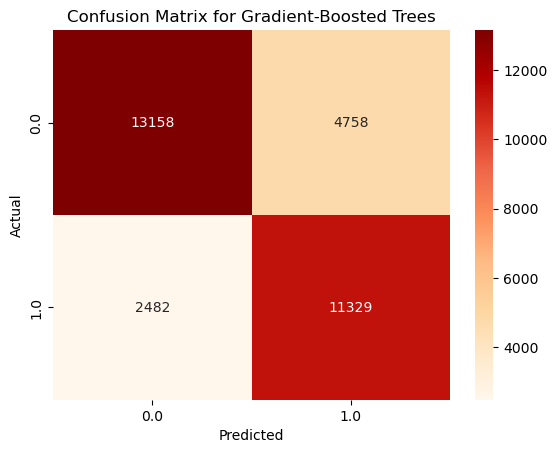

In [32]:
###Evaluate Gradient Boost Model


##Binary Classification Evaluator for AUC (Area Under ROC Curve)
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees AUC: {gbt_auc}")

##Multiclass Classification Evaluator for accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="smoking", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = multiclass_evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees Accuracy: {gbt_accuracy}")

precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees Precision: {precision}")

recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees Recall: {recall}")

f1 = multiclass_evaluator.setMetricName("f1").evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees F1 Score: {f1}")

evalScores["Gradient Boost"] = {"accuracy": gbt_accuracy, "precision": precision, "recall": recall, "f1": f1}
accuracies.append(gbt_accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)

##Confusion Matrix
gbt_predictions.groupBy("smoking", "prediction").count().show()


##Convert predictions to Pandas DataFrame
gbt_pandas_predictions = gbt_predictions.select("smoking", "prediction").toPandas()

##Create a confusion matrix
confusion_matrix = pd.crosstab(gbt_pandas_predictions["smoking"], gbt_pandas_predictions["prediction"], rownames=["Actual"], colnames=["Predicted"])

##Plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd")
plt.title("Confusion Matrix for Gradient-Boosted Trees")
plt.show()


####  Random Forest Evaluation

Random Forest AUC: 0.8293123705119422
Random Forest Accuracy: 0.7526081886090712
Cross-Validated Random Forest AUC: 0.8315637073282993
Cross-Validated Random Forest Accuracy: 0.7540895767012323
Random Forest Precision: 0.7661735118557573
Random Forest Recall: 0.7540895767012323
Random Forest F1 Score: 0.7550465806499087
+-------+----------+-----+
|smoking|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|11197|
|    0.0|       1.0| 5235|
|    1.0|       0.0| 2614|
|    0.0|       0.0|12681|
+-------+----------+-----+



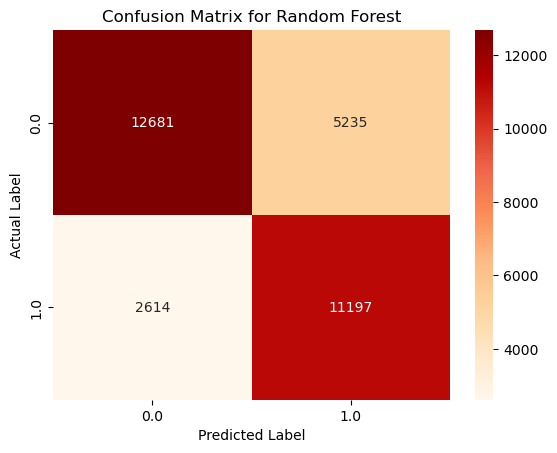

Detailed Results:
              precision    recall  f1-score   support

  non-smoker       0.83      0.71      0.76     17916
      smoker       0.68      0.81      0.74     13811

    accuracy                           0.75     31727
   macro avg       0.76      0.76      0.75     31727
weighted avg       0.76      0.75      0.75     31727






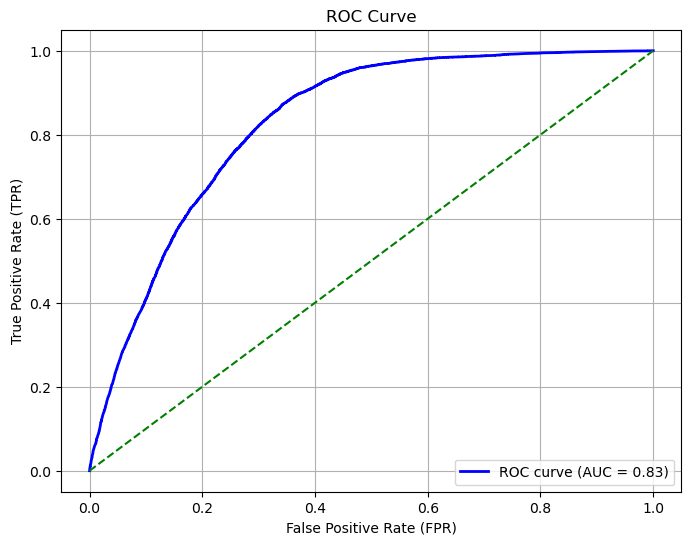

In [34]:
###Evaluate Random Forest


##Binary Classification Evaluator for AUC
evaluator = BinaryClassificationEvaluator(labelCol="smoking", metricName="areaUnderROC")
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest AUC: {rf_auc}")

##Multiclass Classification Evaluator for Accuracy
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="smoking", predictionCol="prediction", metricName="accuracy")
rf_accuracy = multiclass_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

##Cross Validation with Hyperparameter Tuning
#paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 50]).addGrid(rf.maxDepth, [5, 10, 20]).build()
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 80]).build()


crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5
)

cv_model = crossval.fit(train)
cv_predictions = cv_model.transform(test)

##Evaluate Cross-Validated Model
cv_auc = evaluator.evaluate(cv_predictions)
cv_accuracy = multiclass_evaluator.evaluate(cv_predictions)
print(f"Cross-Validated Random Forest AUC: {cv_auc}")
print(f"Cross-Validated Random Forest Accuracy: {cv_accuracy}")

precision = multiclass_evaluator.setMetricName("weightedPrecision").evaluate(cv_predictions)
print(f"Random Forest Precision: {precision}")

recall = multiclass_evaluator.setMetricName("weightedRecall").evaluate(cv_predictions)
print(f"Random Forest Recall: {recall}")

f1 = multiclass_evaluator.setMetricName("f1").evaluate(cv_predictions)
print(f"Random Forest F1 Score: {f1}")

evalScores["Random Forest"] = {"accuracy": cv_accuracy, "precision": precision, "recall": recall, "f1": f1}
accuracies.append(cv_accuracy)
precisions.append(precision)
recalls.append(recall)
f1s.append(f1)


rf_predictions.groupBy("smoking", "prediction").count().show()


##Convert predictions to Pandas DataFrame
rf_pandas_predictions = rf_predictions.select("smoking", "prediction").toPandas()
auc_predictions = rf_predictions.select("smoking", "prediction", "probability").toPandas()

##Create a confusion matrix
confusion_matrix = pd.crosstab(rf_pandas_predictions["smoking"], rf_pandas_predictions["prediction"], rownames=["Actual"], colnames=["Predicted"])

##Plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd", cbar=True)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()



####Get ready to plot a ROC/AUC curve
metrics = classification_report(rf_pandas_predictions["smoking"], rf_pandas_predictions["prediction"], target_names=["non-smoker", "smoker"])
print("Detailed Results:")
print(metrics)
print ("\n\n")


actual = auc_predictions["smoking"]
predicted_proba = auc_predictions["probability"].apply(lambda x: x[1])
fpr, tpr, thresholds = roc_curve(actual, predicted_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="green", linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()





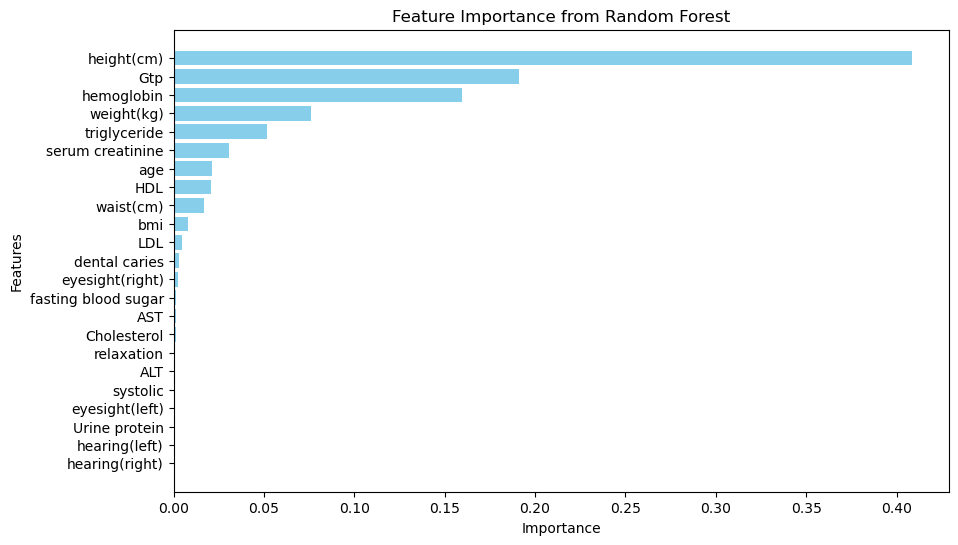

In [36]:
###Feature importance for Random Forest.

##Extract feature importance from the Random Forest model
rf_importances = rf_model.featureImportances.toArray()


rf_feature_importance = {feature: importance for feature, importance in zip(x_features, rf_importances)}

##Sort features by importance
rf_sorted_features = sorted(rf_feature_importance.items(), key=lambda x: x[1], reverse=True)

##Extract features and their importances for plotting
rf_features, rf_importance_values = zip(*rf_sorted_features)

##Now Plot Feature Importance for Random Forest
plt.figure(figsize=(10, 6))
plt.barh(rf_features, rf_importance_values, color='skyblue')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.gca().invert_yaxis() 
plt.show()




### Plot learning curve for our Random forest model.

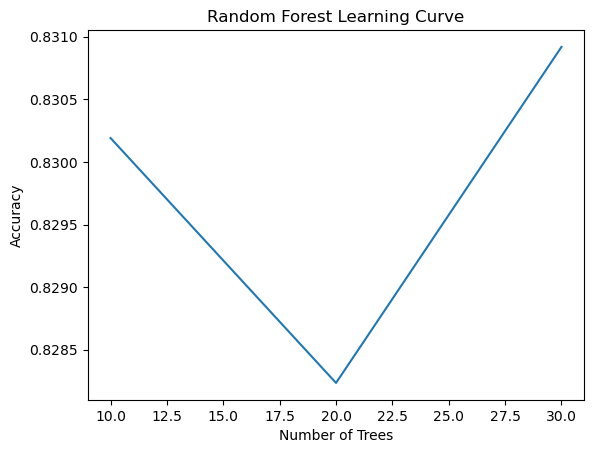

In [39]:
##Plot learning curve for our Random forest.

cv_models = cv_model.avgMetrics

plt.plot([10, 20, 30], cv_models)
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Random Forest Learning Curve")
plt.show()


All in all, our models performed about the same, with each model scoring within a few percentage points of one another. This makes it hard to draw any meaningful conclusions about moel performance. Our best performing model was Gradient Boost, which makes sense because it is a model based on multiple trees, correcting and selecting the best performing tree, leading to better results. Our worst performer was Logistic Regression, which, given the amount of comparison of different columns, makes sense. As stated before, the difference is so minor it is not worth going super in depth in determining which one was better. Something else worth noting was in each models confusion matrix. Each seemed to produce more false positives than negatives. This could be a result the training of our models, which could indicated more work needs to be done in that area.


### Stage 5: Visualization

The best model with accuracy score is Gradient Boost with a score of: 0.7718031960160116
The best model with precision score is Gradient Boost with a score of: 0.7816362675346125
The best model with recall score is Gradient Boost with a score of: 0.7718031960160117
The best model with f1 score is Gradient Boost with a score of: 0.7727500504069779




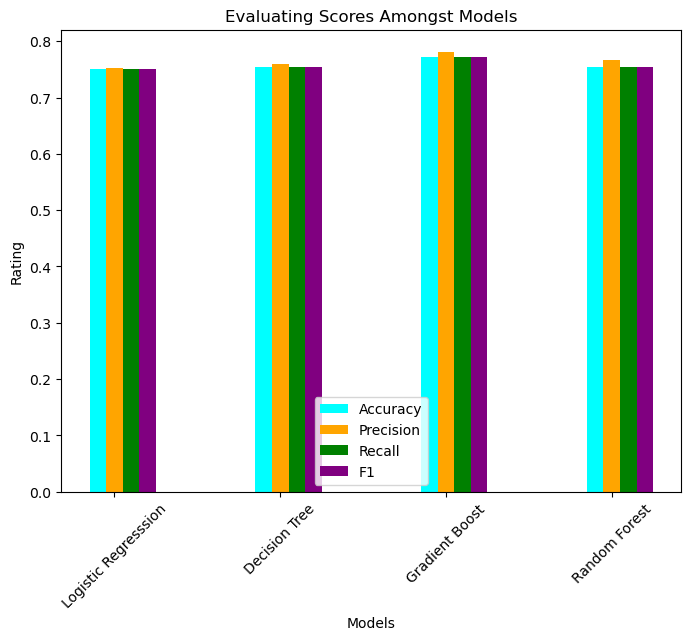

In [43]:
highest = [0,0,0,0]
topModelScores = ["","","",""]

for modelName, evalScore in evalScores.items():
    
    if evalScore["accuracy"] > highest[0]:
        highest[0] = evalScore["accuracy"]
        topModelScores[0] = modelName
        
        
    if evalScore["precision"] > highest[1]:
        highest[1] = evalScore["precision"]
        topModelScores[1] = modelName
        

    if evalScore["recall"] >  highest[2]:
         highest[2] = evalScore["recall"]
         topModelScores[2] = modelName
        

    if evalScore["f1"] > highest[3]:
         highest[3] = evalScore["f1"]
         topModelScores[3] = modelName

print("The best model with accuracy score is", topModelScores[0], "with a score of:",  highest[0])
print("The best model with precision score is", topModelScores[1], "with a score of:",  highest[1])
print("The best model with recall score is", topModelScores[2], "with a score of:",  highest[2])
print("The best model with f1 score is", topModelScores[3], "with a score of:",  highest[3])
print('\n')

x = np.arange(4)
width = 0.1
plt.figure(figsize=(8,6))
plt.title('Evaluating Scores Amongst Models')
plt.bar(x-width, accuracies, width, color='cyan') 
plt.bar(x, precisions, width, color='orange') 
plt.bar(x+width, recalls, width, color='green') 
plt.bar(x+width*2, f1s, width, color='purple') 
plt.xticks(x, list(evalScores.keys()), rotation=45) 
plt.xlabel("Models") 
plt.ylabel("Rating") 
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1']) 
plt.show()


## Limitations, Future Work, and Conclusion

### Limitations

A big limitation of this dataset is its ability to see only physical characteristics, such as height and weight, but not see other important factors such as how much someone smokes. Additionally, some data in here may be skewing the results, such as the inclusion of height and weight. It has been well documented that the taller someone is, the more they weigh. Although it is not statistically significant enough to show any major changes in results, it is still something to consider.
There are several other potential limitations of the dataset. While some of these are dataset-agnostic, others may apply specifically based on common issues in healthcare-related datasets or bio-signal-based classification tasks. Data from Bio-signals are often prone to noise due to sensor inaccuracies, environmental conditions, or just plain old user error during data collection.  The fact that the data is artifically generated is perhaps not high up on our list of concerns, but in general, a keen and strict process for validating Bio-signals collected data would be a welcomed addition. Also, we must not overlook the number of features included with the dataset. Actually, 24 columns may not sound like a lot, but they all may not be relevant to helping us predict the overall smoking status. Irrelevant features can render our model(s) to be less interpretable.

When working with true Bio-signals collected data, then the swings and variations in the time of day, activity level, or emotional state could influence the overall signals that are reported.  These variations can introduce noise, reducing the consistency of patterns related to smoking status. We would need to determine how to properly address this.
Additioanally, Bio-signal data would be highly sensitive, and any data leakage or misuse could lead to serious ethical and privacy violations. So there would absolutely be a need to Limit the data's usability in certain applications or requires strong anonymization techniques. Thus robust anonymization, encryption methods would need to apply, and data governance laws like HIPPA, etc would need to be considered.

Lastly, we mentioned the total number of columns above, but we would also need to pay close attention to the actual features that are represented by each column, and not just the sheer number of cloumns. Meaning that the The dataset may not include relevant/sufficient features (e.g., lifestyle factors, genetic predispositions, or other health indicators) that may correlate well with smoking status. Probably a good example is that the Liver as an organ was well represented in the dataset with the two Liver enzyme features of AST (Aspartate transaminase) and ALT (Alanine transaminase). However, perhaps a case can be made to also possible include some features that is more central to the human lung and its bodily functions, since it is suspected that smoking has varying effects on an individual's lung. So, the absence of complementary information could lead to incomplete modeling and reduced predictive power that could lead to us having less than stellar comprehensive model predictive analysis.

health.


### Future Work

This dataset is unique in that it is a subset of another dataset generated by a deep learning model, which means you would have to add on to it yourself if you wanted to expand the dataset. Future work could include looking more closely at the physical characteristics and comparing them on an individual basis, so things like smoking to weight, or smoking to dental caries. That would paint a much clearer picture as to what exactly smoking affects physically. Another key detail that would add much needed context is how much someone smokes and the effect that has on someone's physical characteristics. Additionally, the dataset is missing some physical characteristic identifiers, like male and female. Something else to consider for the future would be looking at non physical characteristics, such as marital status, education, family history, and how addicted someone is.

### Conclusion

Looking at the different models, they all score about the same within a just percentage point or two of one another. Gradient Boost performed the best, with Logistic Regression doing the worst as seen above, but it is hard to draw any meaningful conclusion when the models are so close that a difference in seed could flip the outcomes. Something that is interesting we found is that the correlation matrix for each algorithm always seems to produce more false positives than false negatives. This project's goal was to analyze physical characteristics of smokers to identify potential patterns through parameter tuning, visualizations, and evaluation with the goal of informing public health strategies and health education efforts. Overall, our results show that there is a correlation between physical characteristics like height, weight, and eyesight to smoking, with all of our algorithms showing at least 0.73 accuracy. This aligns with other studies done about smoking and/overall general health.

A key insight of the project shows that an high or elevated hemoglobin can be a good indicator that an individual can be classified as a smoker. Many companies/employers today require that their employees pay a much higher premium for health care - if that employee is classifed as a smoker. Thus time/effort/resources then must be spent to determine how to best classify an employee as a smoker or non-smoker.  So, to help fill that gap machine learning models like what we've done in this project - though not 100% foolproof would be able to help with such smoker/non-smoker classification.  This could not only assist with overall employee/patient care, but could also contribue to the larger goal of reducing the impact of smoking-related diseases on the overal public.

So, our dataset for predicting smoker status using bio-signals presents a rather unique opportunity to leverage machine learning for overall healthcare analytics. The dataset contains a combination of numerical and categorical features, thus offering insights into physiological patterns that may correlate with smoking behavior. However, just like many healthcare datasets, it does come with potential limitations such as class imbalance, noise in the collected bio-signals, duplicate values, and potentially redundant features. So we would attempt to address these challenges through data preprocessing, cleaning, and careful feature engineering to maximize the dataset's utility for predictive modeling.

Our machine learning process involved an end-to-end pipeline that started with exploring and preparing the dataset. This included removing duplicate values, removing unwanted/undesired features, transforming the data for compatibility with machine learning models, and then applying techniques to improve the viability of the dataset. We selected multiple supervised learning models—Logistic Regression, Random Forest, Gradient-Boosted Trees, and Decision Tree - to evaluate their performance. Each of our model was tuned using hyperparameter optimization and validated using cross-validation to ensure robustness. Metrics such as AUC and accuracy were used to evaluate model performance, with additional visualizations like confusion matrices to help interpret predictions.
Among our models, the ensemble methods like Gradient-Boosted Trees and Random Forest demonstrated the highest potential due to their ability to handle complex relationships and provide robust predictions. Simpler models like Logistic Regression were just a bit faster to train but struggled with non-linearities and feature dependencies. Overall our ML pipeline provided actionable insights and reliable predictions for smoker classification, illustrating the power of machine learning in extracting meaningful patterns from the dataset.

